# Задача

Построить прогноз количества перерабатываемых контейнеров на год вперед.

Загружаем библиотеки.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
%run f2forecast.py

Читаем файл с данными (лист 'Data').

In [3]:
df=pd.read_excel("sample_dataset.xlsx", index_col='Xm', sheet_name='Data')
df.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [4]:
df.tail()

,Y
Xm,
2018-12-01,1777
2019-01-01,1536
2019-02-01,1190
2019-03-01,1530
2019-04-01,1840


Исходные набор содержит данные по месяцам с января 2015 года о апрель 2019 года.

Выполним валидацию данных и выведем на экран значения.

In [5]:
df = validate_series(df)
print(df)

               Y
Xm              
2015-01-01  1388
2015-02-01  1088
2015-03-01  1813
2015-04-01  1523
2015-05-01  1595
2015-06-01  1475
2015-07-01  1657
2015-08-01  1506
2015-09-01  1208
2015-10-01  1506
2015-11-01  1544
2015-12-01  1583
2016-01-01   997
2016-02-01  1264
2016-03-01  1238
2016-04-01  1370
2016-05-01  1305
2016-06-01  1351
2016-07-01  1603
2016-08-01  1433
2016-09-01  1343
2016-10-01  1430
2016-11-01  1555
2016-12-01  1663
2017-01-01  1090
2017-02-01  1047
2017-03-01  1608
2017-04-01  1263
2017-05-01  1482
2017-06-01  1921
2017-07-01  1905
2017-08-01  1991
2017-09-01  1072
2017-10-01  2054
2017-11-01  1616
2017-12-01  1192
2018-01-01  1249
2018-02-01  1453
2018-03-01  2200
2018-04-01  2024
2018-05-01  2268
2018-06-01  1902
2018-07-01  2150
2018-08-01  2016
2018-09-01  1679
2018-10-01  1670
2018-11-01  1726
2018-12-01  1777
2019-01-01  1536
2019-02-01  1190
2019-03-01  1530
2019-04-01  1840


Построим график по месяцам на всем периоде.

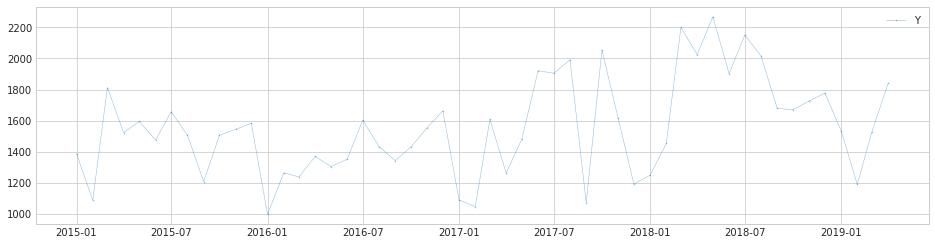

In [6]:
plot(df)

Посмотрим основные статистики ряда данных.

In [7]:
df.describe()

,Y
count,52.000000
mean,1555.557692
std,315.367847
min,997.000000
25%,1333.500000
50%,1533.000000
75%,1738.750000
max,2268.000000


Среднее значение набора не очень близко к медиане, что позволяет нам говорить о нормальном распределении значений. 

Посмотрим на точки, которые легли выше 2200 контейнеров и ниже 1000 контейнеров. Потенциально эти значения могут быть выбросами. 

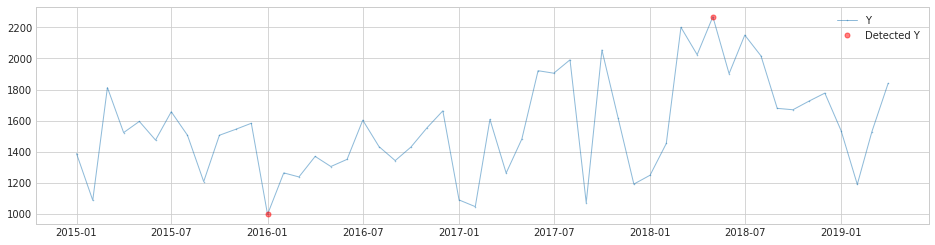

In [8]:
threshold_ad = ThresholdAD(high=2200, low=1000)
anomalies = threshold_ad.fit_detect(df)
plot(df, anomaly_pred=anomalies, ts_linewidth=1, ap_markersize=5, ap_color='red', ap_marker_on_curve=True)

In [9]:
anomalies[anomalies.Y]

,Y
Xm,
2016-01-01,True
2018-05-01,True


Аномалии пришлись на две точки. Потенциально, в мае 2018 года может быть выброс. Этот период надо изучить детальнее.

Посмотрим на выбросы при помощи метода OutlierDetector и попробуем менять уровень значимости от 0.01 до 0.1.

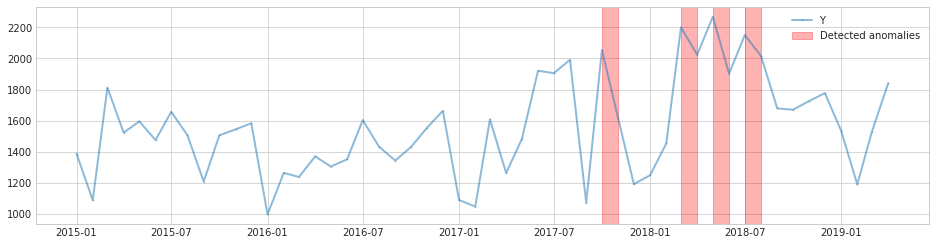

In [10]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.06))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly_pred=anomalies, ts_linewidth=2, ap_color='red', ap_alpha=0.3, curve_group='all');

In [11]:
anomalies[anomalies]

Xm
2017-10-01    True
2018-03-01    True
2018-05-01    True
2018-07-01    True
dtype: bool

Мы видим, что есть все признаки выброса в периоде первой половины 2018 года. Для окончательного заключения изучим отклонения в сезонной компоненте. 

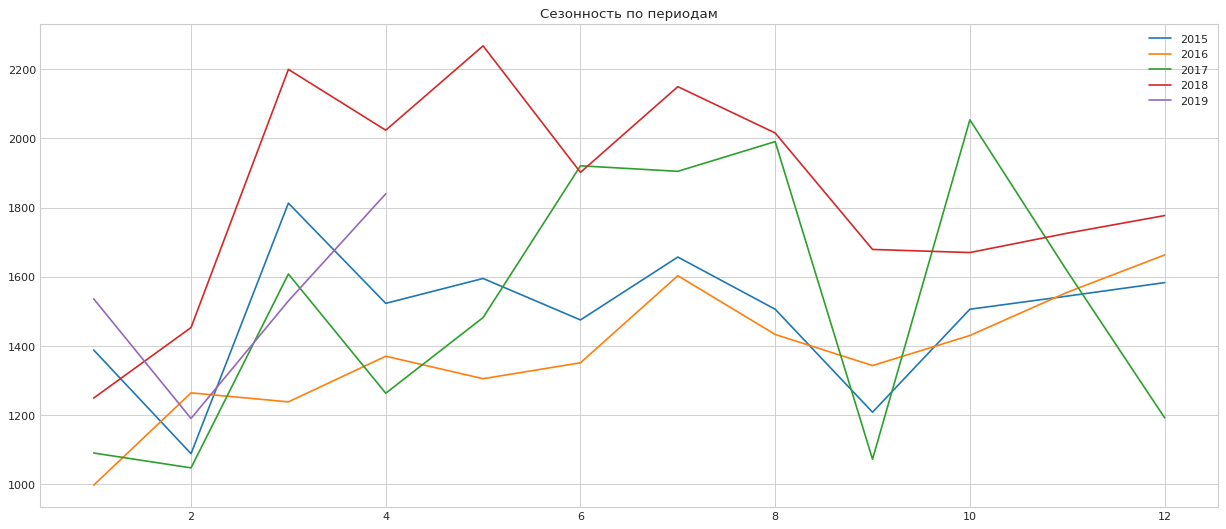

In [12]:
sesonal(df,12) #количество периодов в году, в данном случае строим по месяцам

Изучив фактические данные и результаты анализа на выбросы, делаем заключение, что выбросы есть в четырех периодах:
03-05.2018 и 07.2018. Первую точку возьмем по аналогии с 2015 годом, на сезонном графике видно, что динамика этих лет примерно совпадает. А вторую, возьмем по аналогии с 07.2017 года. 

**Методические рекомендации:** *постарайтесь подробнее расписать причины отклонений и почему выбрали именно эти точки в выбросах.*

In [13]:
df.loc['2018-03-01'].Y=df.loc['2015-03-01'].Y
df.loc['2018-04-01'].Y=df.loc['2015-04-01'].Y
df.loc['2018-05-01'].Y=df.loc['2015-05-01'].Y
df.loc['2018-07-01'].Y=df.loc['2017-07-01'].Y

Оценим результаты корректировок.

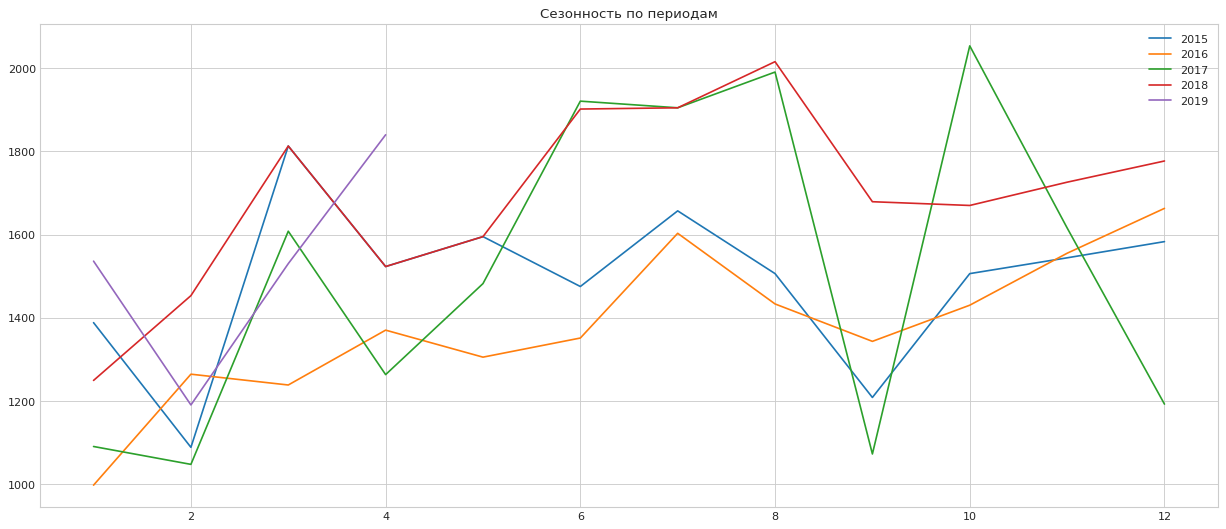

In [14]:
sesonal(df,12)

# Декомпозиция: тренд и сезонность

Оценим стабильность тренда, сезонности и возможность использования всего ряда данных. 

Оченим ряд через мультипликативную представленность. 

Text(0.5, 0.98, 'Мультипликативная модель')

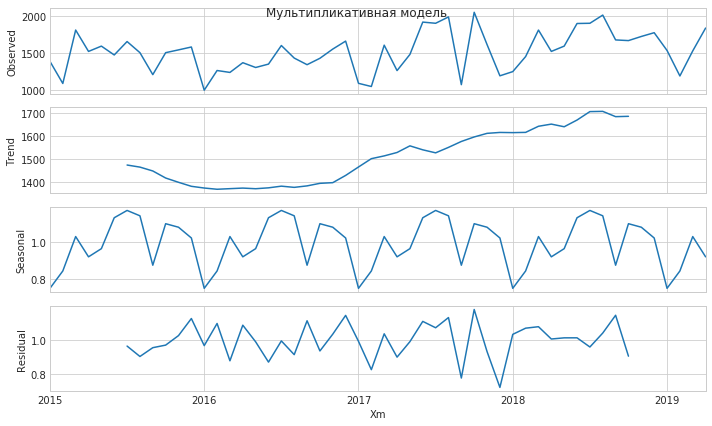

In [15]:
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative', freq=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,6)})
result_M.plot().suptitle('Мультипликативная модель')

Адитивное разложение ряда. 

Text(0.5, 0.98, 'Адитивная модель')

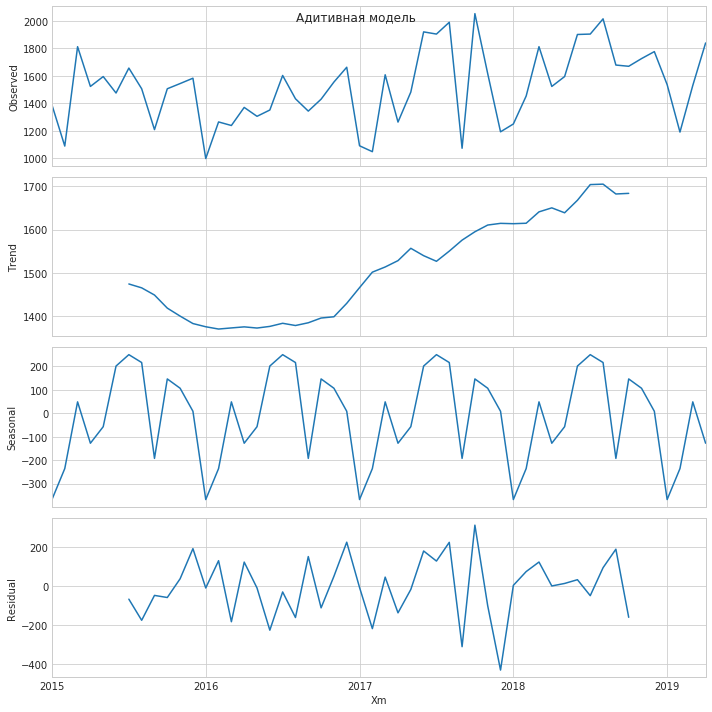

In [16]:
# Decompose 
result_A = seasonal_decompose(df.Y, model='additive', freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

Несмотря на небольшой слом тренда будем использовать полный набор данных. Если не сможем обеспечить необходиму точность и алгоритмы не смогут "отловить" слом, можем перейти к использованию данных только с 2016 года. Ограниченный набор данных в этом случае не позволит выделить тестовую выборку.

Также скорее всего, оптимальнее будет мультипликаивная модель ряда, так как она демонстрирует более пологий тренд и меньший разброс остатков.

**Методические указания**: *постарайтесь найти ряд за пять и более лет.*

# Тренировочные и тестовые данные

Разделим данные на тренировочные и тестовые. В качестве тестовых возьмем результаты января-апреля 2019 года.

**Методические указания**: *тестовые данные обучно составляют около 5% до 20% от всего набора.*

In [17]:
train=df[:'2018']
train.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [18]:
test=df['2019':]
test.head()

,Y
Xm,
2019-01-01,1536
2019-02-01,1190
2019-03-01,1530
2019-04-01,1840


# Модель Хольта-Винтерса

Построим модели Хольта-Винтерса. Начнем с модели с адитивным трендом и мультипликативной сезонностью.

In [19]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()
fit1.params

{'smoothing_level': 0.2069736891955232,
 'smoothing_slope': 0.20697365963843273,
 'smoothing_seasonal': 0.0,
 'damping_slope': nan,
 'initial_level': 1181.0018244247517,
 'initial_slope': 0.0,
 'initial_seasons': array([1.11556067, 1.13056617, 1.52114961, 1.32534345, 1.39481007,
        1.54894937, 1.63999109, 1.62317534, 1.216222  , 1.53962741,
        1.46740388, 1.40305238]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Судя по коэффициентам сглаживания, лучшей стратегией является использование для прогноза последних результатов.

In [20]:
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -7.592
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 136.226
MSE: 30659.0766
MAPE: 0.0938
MPE: -0.0072
Стандартная ошибка: 175.0973


Мы видим, что остатки стационарны и модель можем использовать без ограничений. 

Модель является несколько переоценивающей (на 072%). Средняя абсолютная ошибка 9.38%, что в целом может быть вполне премлемо.  

Построим варианты модели с другими видами тренда и сезонности.

In [21]:
fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='mul').fit()
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -7.871
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 137.6183
MSE: 29712.4252
MAPE: 0.0929
MPE: 0.0053
Стандартная ошибка: 172.3729


In [22]:
fit3 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
metrics(train, fit3.fittedvalues)

Тест на стационарность:
	T-статистика = -6.992
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 140.8604
MSE: 47023.0645
MAPE: 0.0955
MPE: 0.0015
Стандартная ошибка: 216.848


In [23]:
fit4 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='add').fit()
metrics(train, fit4.fittedvalues)

Тест на стационарность:
	T-статистика = -7.145
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 146.2908
MSE: 46398.7441
MAPE: 0.099
MPE: 0.0057
Стандартная ошибка: 215.4037


Наиболее точной оказалась модель (2) с мультипликативным трендом и мультипликативной сезонностью. У этой модели наименьшая среднеквадратическая ошибка, остатки стационарны.

Лучшая модель имеет среднюю абсолютную ошику в 9.55%, на 0.53% является переоценивающей и 95% доверительный интервал +/- 344 контейнеров.

Построим график фактического ряда, модели, прогноза лучшей модели и тестовго набора данных. 

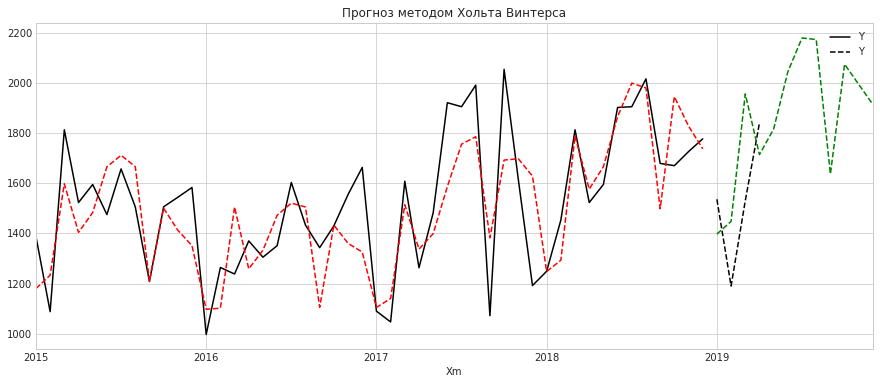

In [29]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
test.plot(ax=ax, style='--', color='black')
fit2.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Черной пунктирной линией отображен тестовый период по отношению к спрогнозированному. Надо проверить, не будут ли другие модели точнее в части предсказания тестовых данных.

In [25]:
metrics(test, fit1.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.718
	P-значение = 0.422
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 230.0507
MSE: 62236.9968
MAPE: 0.1565
MPE: -0.066
Стандартная ошибка: 249.4734


In [26]:
metrics(test, fit2.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.746
	P-значение = 0.408
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 237.1631
MSE: 70782.2894
MAPE: 0.1635
MPE: -0.0841
Стандартная ошибка: 266.0494


In [27]:
metrics(test, fit3.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.675
	P-значение = 0.444
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 224.7881
MSE: 71991.094
MAPE: 0.158
MPE: -0.108
Стандартная ошибка: 268.3116


In [28]:
metrics(test, fit4.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.685
	P-значение = 0.439
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 224.7313
MSE: 77463.9143
MAPE: 0.1594
MPE: -0.1203
Стандартная ошибка: 278.3234


К сожалению, даже лучшая модель, не очень хорошо дает прогноз на будущий период по отношению к Модель (1) с адитивным трендом и мультипликативной сезонностью демонстрирует лучшие результаты. Построим ее график.

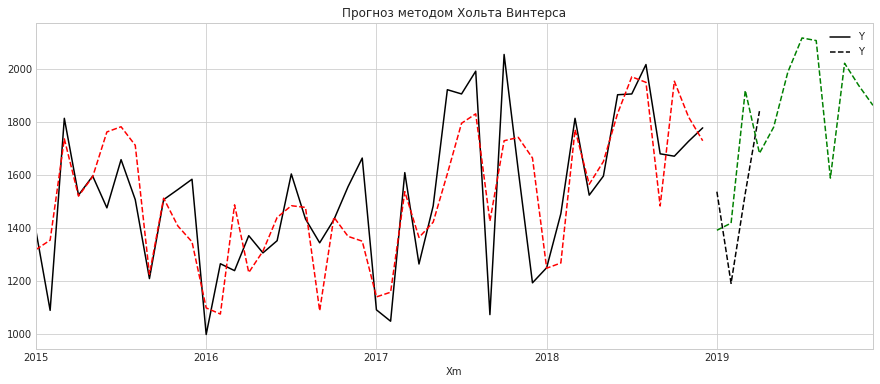

In [30]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
test.plot(ax=ax, style='--', color='black')
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Попробуем построить более точную модель по методу SARIMA.

# SARIMA

Сделаем прогноз методом SARIMA. Но предварительно изучим данные на предмент наличия автокорреляции в ряду.

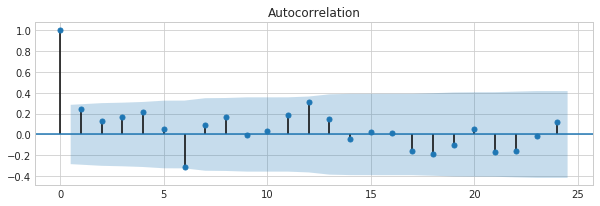

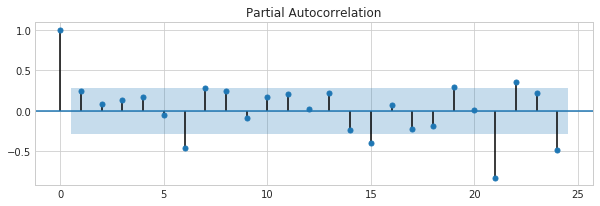

In [31]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.Y, lags=24)
plot_pacf(train.Y, lags=24)
plt.show()

На графике автокорреляции мы видим, что в ряду содержиться очень слабый тренд. И сезонность не каждые 12-ть месяцев, а 6 месяцев. Это некотрое исключение.

Попробуем подобрать параметры модели.

In [32]:
model = auto_arima(train, seasonal=True, m=6, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 6); AIC=656.801, BIC=671.603, Fit time=0.442 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 6); AIC=683.326, BIC=687.026, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 6); AIC=658.993, BIC=666.393, Fit time=0.084 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 6); AIC=653.255, BIC=660.656, Fit time=0.158 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 6); AIC=681.355, BIC=683.205, Fit time=0.008 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 6); AIC=662.453, BIC=668.004, Fit time=0.044 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 6); AIC=652.214, BIC=661.465, Fit time=0.294 seconds
Near non-invertible roots for order (0, 1, 1)(1, 0, 1, 6); setting score to inf (at least one inverse root 

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 2, 6),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [33]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 2, 6))

results = mod.fit()

print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 Y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 0, 2, 6)   Log Likelihood                -321.016
Date:                           Sun, 05 Jan 2020   AIC                            650.031
Time:                                   15:51:33   BIC                            657.432
Sample:                               01-01-2015   HQIC                           652.816
                                    - 12-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7372      0.125     -5.907      0.000      -0.982      -0.493
ma.S.L6       -0.6042      0.154     -3.917

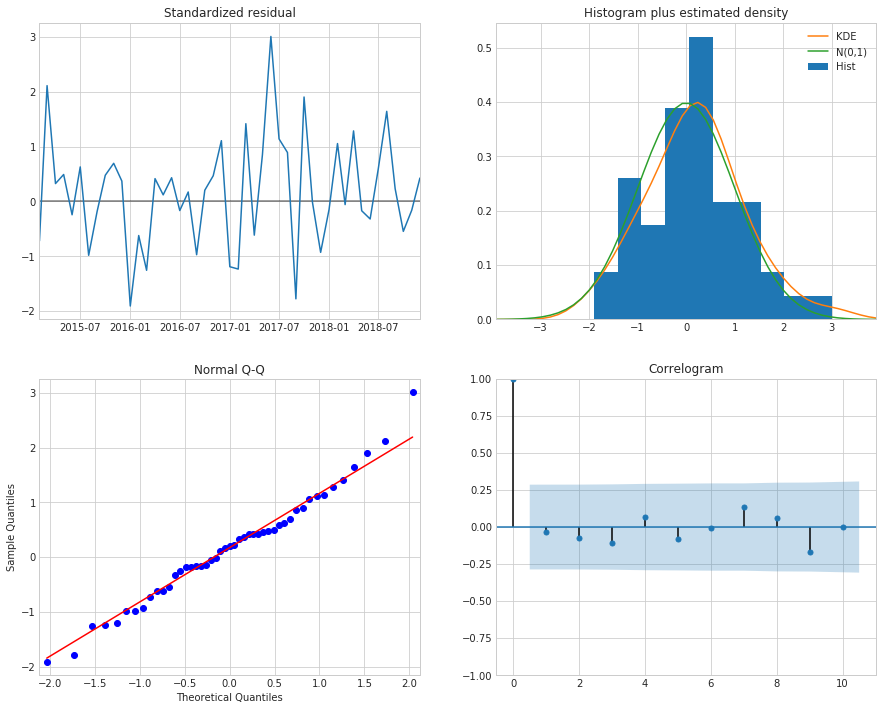

In [34]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Остатки случайны, закономерностей нет. Распределение в целом нормальное.

In [37]:
results.fittedvalues

Xm
2015-01-01       0.000000
2015-02-01    1322.824234
2015-03-01    1202.732590
2015-04-01    1432.789197
2015-05-01    1461.658913
2015-06-01    1540.019467
2015-07-01    1496.434299
2015-08-01    1736.581174
2015-09-01    1249.669450
2015-10-01    1399.095176
2015-11-01    1389.462291
2015-12-01    1500.691222
2016-01-01    1418.274728
2016-02-01    1401.009456
2016-03-01    1514.582499
2016-04-01    1278.345437
2016-05-01    1278.461864
2016-06-01    1255.829476
2016-07-01    1638.908666
2016-08-01    1395.764304
2016-09-01    1551.972212
2016-10-01    1385.942755
2016-11-01    1454.283238
2016-12-01    1425.063695
2017-01-01    1344.459566
2017-02-01    1309.738214
2017-03-01    1306.326609
2017-04-01    1393.538663
2017-05-01    1300.429132
2017-06-01    1282.025321
2017-07-01    1662.735405
2017-08-01    1801.481060
2017-09-01    1448.958133
2017-10-01    1649.643105
2017-11-01    1619.891437
2017-12-01    1389.008620
2018-01-01    1279.689204
2018-02-01    1229.351852
2018-03-0

Так как используется скользящая средняя, модель не может делать прогнозы для первой даты. Сравним точность начиная со второго периода. 

In [38]:
predict=results.get_prediction(start=pd.to_datetime('2015-02-01'))
metrics(train['2015-02-01':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -7.169
	P-значение = 0.000
Критические значения :
	1%: -3.5812576580093696 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9267849124681518 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6015409829867675 - Данные  стационарны с вероятностью 90% процентов
MAD: 174.7253
MSE: 51098.3072
MAPE: 0.1192
MPE: 0.0058
Стандартная ошибка: 226.0493


Остатки стационарны, точность несколько ниже на тренировочных данных, чем у модели-Хольта Винтерса. Сравним результаты с тестовыми данными и построим график. 

In [39]:
metrics(test, results.forecast(len(test)))

Тест на стационарность:
	T-статистика = -1.250
	P-значение = 0.652
Критические значения :
	1%: -10.41719074074074 - Данные не стационарны с вероятностью 99% процентов
	5%: -5.77838074074074 - Данные не стационарны с вероятностью 95% процентов
	10%: -3.391681111111111 - Данные не стационарны с вероятностью 90% процентов
MAD: 179.0044
MSE: 53546.7584
MAPE: 0.1357
MPE: -0.1357
Стандартная ошибка: 231.4017


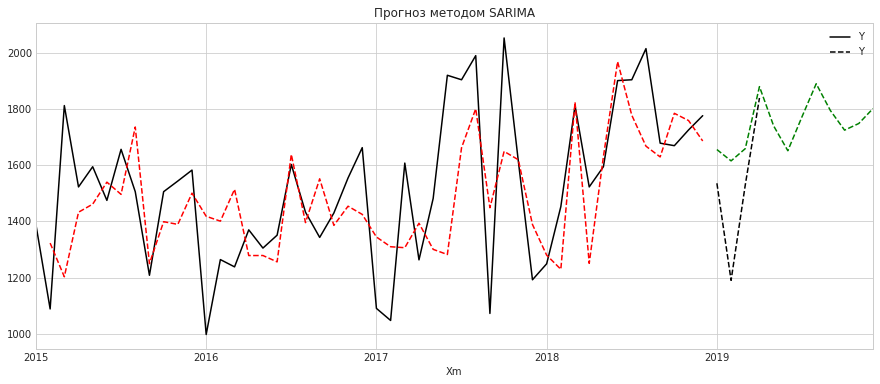

In [40]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
test.plot(ax=ax, style='--', color='black')
predict.predicted_mean.plot(ax=ax, style='--', color='red')
results.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

In [ ]:
Мы видим, что хотя в целом модель ARIMA оказалась менее точной при сравнениии тренировочными данными, на тестовых, если судить по среднеквадратическому отклонению, она оказалась чуть более точной.Здесь можем не обращать внимание на стационарность остатков, так как ряд очень короткий.

В целом, точность прогноза тестовых данных не удовлетворительная. Возможно, это связано с нечеткой сезонностью ряда. Попробуем укрупнить даные до кварталов и построить прогнозные модели.

# Кварталы


Укрупняем данные до кварталов. Так как у нас за 2019 год данные только за 4 месяца, то получится один квартал.

In [41]:
df=df[:"2019-03-01"].resample('Q').sum()

Проведем валидацию данных на отсутствие пропусков.

In [43]:
df = validate_series(df)
print(df)

               Y
Xm              
2015-03-31  4289
2015-06-30  4593
2015-09-30  4371
2015-12-31  4633
2016-03-31  3499
2016-06-30  4026
2016-09-30  4379
2016-12-31  4648
2017-03-31  3745
2017-06-30  4666
2017-09-30  4968
2017-12-31  4862
2018-03-31  4515
2018-06-30  5020
2018-09-30  5600
2018-12-31  5173
2019-03-31  4256


Построим график и посмотрим основные параметры нашего ряда. 

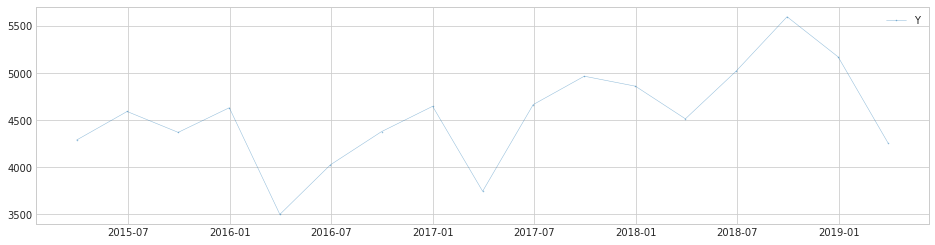

In [44]:
plot(df)

In [45]:
df.describe()

,Y
count,17.000000
mean,4543.705882
std,515.932864
min,3499.000000
25%,4289.000000
50%,4593.000000
75%,4862.000000
max,5600.000000


Отобразим точки на графике, которые больше 6100 контейнеров в квартал и меньше 3600.

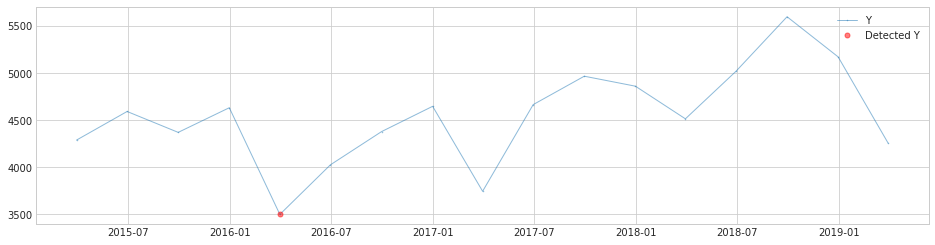

In [46]:
threshold_ad = ThresholdAD(high=6100, low=3600)
anomalies = threshold_ad.fit_detect(df)
plot(df, anomaly_pred=anomalies, ts_linewidth=1, ap_markersize=5, ap_color='red', ap_marker_on_curve=True)

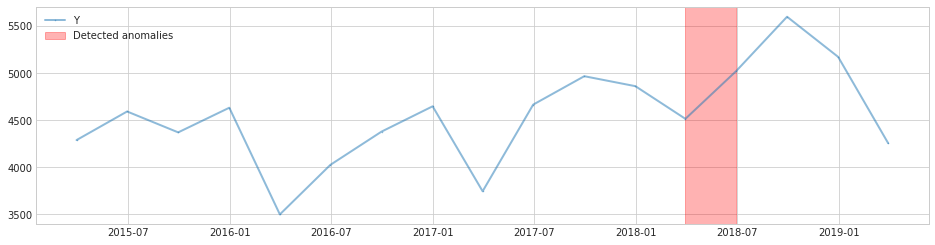

In [47]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.06))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly_pred=anomalies, ts_linewidth=2, ap_color='red', ap_alpha=0.3, curve_group='all');

In [48]:
anomalies[anomalies]

Xm
2018-03-31    True
Freq: Q-DEC, dtype: bool

Детектор аномалий при уровне чувствительности 0.6 показывает одну аномалия в 4-м квартале 2017 года. 

Взглянем на сезонную компоненту. 

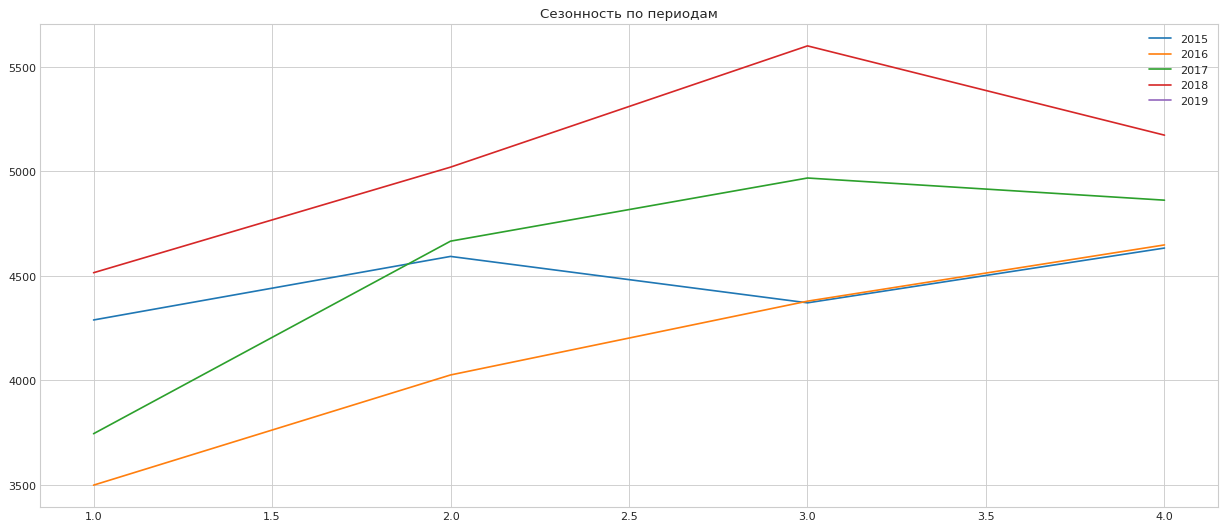

In [49]:
sesonal(df,4)

Четвертый квартал 2017 года несколько ниже, чем ожидается. График подтверждает выброс, выявленый детектором аномалий. Попробуем несколько исправить положение, присвоив четвертому кварталу среднее значение третьего квартала 2017 года и первого 2018 года.

In [50]:
df.loc['2017-12-31']=(df.loc['2017-09-30']+df.loc['2018-03-31'])/2

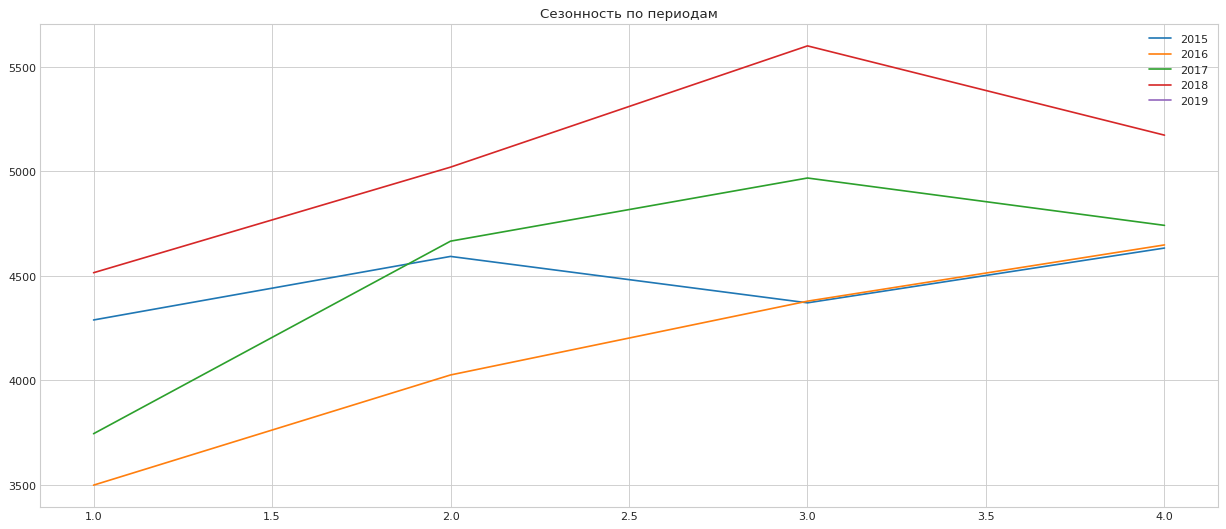

In [51]:
sesonal(df,4)

Мы помним, что корректировки вносились в месячные данные. Не стоит повтоно прибегать к ним. Или, при необходимости, мы сделаем их на оригинальном ряду. 

В целом очевидно, что 2019 год уже является нестандартным. Но, к сожалению, у нас слишком мало данных чтобы говорить о среднесрочных циклах или однозначной аномалии.

# Декомпозиция: тест и сезонность

Выполним декомпозицию по мультипликативной и адитивной модели.

Text(0.5, 0.98, 'Мультипликативная модель')

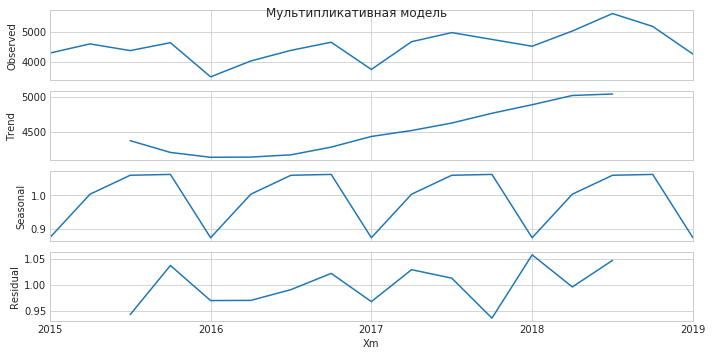

In [52]:
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative', freq=4)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,5)})
result_M.plot().suptitle('Мультипликативная модель')

Text(0.5, 0.98, 'Адитивная модель')

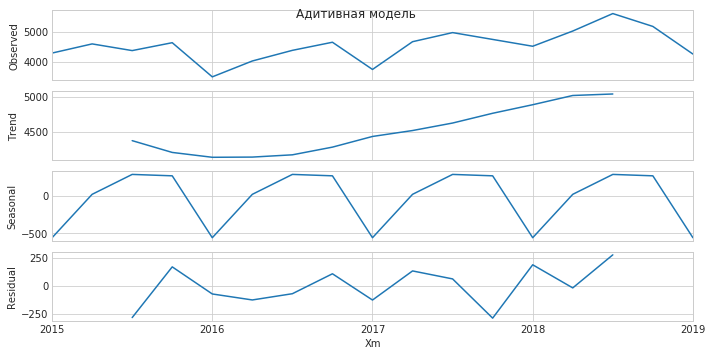

In [53]:
# Decompose 
result_A = seasonal_decompose(df.Y, model='additive', freq=4)

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
result_A.plot().suptitle('Адитивная модель')

В ряду мы наблюдаем явный как тренд, так и сезонную компоненту. Визуально, и аддитивная и мультипликативная модели выглядят одинаково предпочтительно.

# Тренировочные и тестовые данные

Разделим данные на тренировочные и тестовые. В качестве тестовых возьмем три последних квартала.

In [54]:
train=df[:'2018-06-30']
train.tail()

,Y
Xm,
2017-06-30,4666.0
2017-09-30,4968.0
2017-12-31,4741.5
2018-03-31,4515.0
2018-06-30,5020.0


In [55]:
test=df['2018-09-30':]
test.head()

,Y
Xm,
2018-09-30,5600.0
2018-12-31,5173.0
2019-03-31,4256.0


# Модель Хольта-Винтерса

Построим четыре варианта модели Хольта-Винтерса.

In [56]:
fit1 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul').fit()
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -2.572
	P-значение = 0.099
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные не стационарны с вероятностью 90% процентов
MAD: 233.8883
MSE: 72518.3014
MAPE: 0.054
MPE: -0.0033
Стандартная ошибка: 269.2922


In [57]:
fit2 = ExponentialSmoothing(train, seasonal_periods=4, trend='mul', seasonal='mul').fit()
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -23.281
	P-значение = 0.000
Критические значения :
	1%: -4.6651863281249994 - Данные  стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные  стационарны с вероятностью 90% процентов
MAD: 249.1793
MSE: 79550.645
MAPE: 0.056
MPE: 0.0112
Стандартная ошибка: 282.0472


In [58]:
fit3 = ExponentialSmoothing(train, seasonal_periods=4, trend='mul', seasonal='add').fit()
metrics(train, fit3.fittedvalues)

Тест на стационарность:
	T-статистика = -2.456
	P-значение = 0.127
Критические значения :
	1%: -4.137829282407408 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.1549724074074077 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.7144769444444443 - Данные не стационарны с вероятностью 90% процентов
MAD: 262.1785
MSE: 111620.5396
MAPE: 0.0622
MPE: -0.0137
Стандартная ошибка: 334.0966


In [59]:
fit4 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add').fit()
metrics(train, fit4.fittedvalues)

Тест на стационарность:
	T-статистика = -3.305
	P-значение = 0.015
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные  стационарны с вероятностью 90% процентов
MAD: 225.9437
MSE: 69704.5483
MAPE: 0.0507
MPE: 0.005
Стандартная ошибка: 264.0162


По оценке на тренировочных данных у модели (4) с аддитивным трендом и адитивной сезонностью выше точность. Проверим модели на тестовых данных.

In [60]:
metrics_short(test, fit1.forecast(len(test)))

MAD: 256.7868
MSE: 84708.1162
MAPE: 0.0508
MPE: 0.001
Стандартная ошибка: 291.0466


In [61]:
metrics_short(test, fit2.forecast(len(test)))

MAD: 409.203
MSE: 191618.8866
MAPE: 0.0863
MPE: -0.0611
Стандартная ошибка: 437.7429


In [62]:
metrics_short(test, fit3.forecast(len(test)))

MAD: 288.3483
MSE: 121230.9267
MAPE: 0.061
MPE: -0.0211
Стандартная ошибка: 348.1823


In [63]:
metrics_short(test, fit4.forecast(len(test)))

MAD: 419.6282
MSE: 198573.4959
MAPE: 0.0884
MPE: -0.0538
Стандартная ошибка: 445.6159


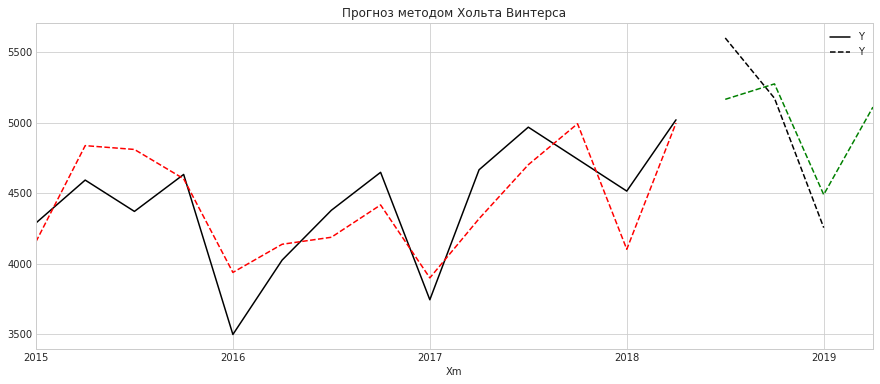

In [64]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
test.plot(ax=ax, style='--', color='black')
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(4).plot(ax=ax, style='--', color='green')
plt.show()

Мы видим, что модель (1) показала неплохой результат в части сопоставления с тестовыми данными. Точность составиля в среднем 8.8%, что выше, чем в случае с месячными данными. В целом квартальная модель показывает себя более точной, что и следовало ожидать. 

# SARIMA

Построим по-квартальную модель методом SARIMA.

Изучим результаты автокореляции. 

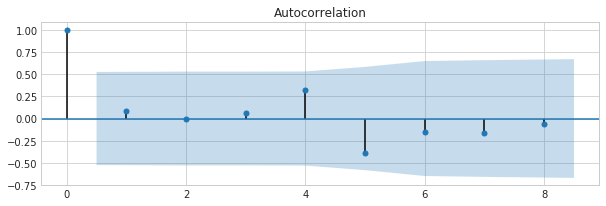

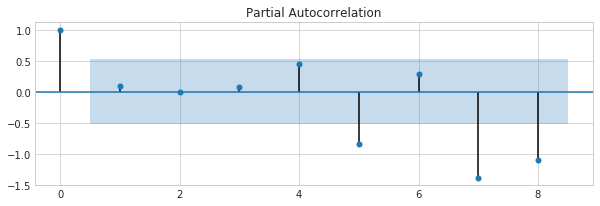

In [66]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.Y, lags=8)
plot_pacf(train.Y, lags=8)
plt.show()

Что интересно, модель автокрелляции указывает скорее на среднесрочные циклы 5, 7 и 8 кварталов. Но данных, тчобы делать подобные заключения у нас маловато. Четкого тренда и квартальной сезонности статистически не видно, но попробуем использовать сезонную модель. 

In [67]:
model = auto_arima(train, seasonal=True, m=4, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 4); AIC=219.030, BIC=224.143, Fit time=0.337 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 4); AIC=212.675, BIC=213.953, Fit time=0.006 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 4); AIC=215.898, BIC=218.455, Fit time=0.027 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 4); AIC=211.291, BIC=213.847, Fit time=0.092 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 4); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 4); AIC=276.979, BIC=277.618, Fit time=0.004 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 4); AIC=214.661, BIC=216.578, Fit time=0.011 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 4); AIC=211.043, BIC=212.960, Fit time=0.046 seconds
Near non-invertible roots for order (0, 0, 0)(0, 0, 1, 4); setting score to inf (at least one inverse root 

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 1, 4),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

Лучшая по автоподбору модель (order=(0, 0, 0), seasonal_order=(0, 0, 1, 4)) оказалась нерелеватна при построении. Мы методом перебора выбрали иную из предложенных автоподбором.

In [68]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 2),
                                seasonal_order=(1, 0, 1, 4))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0045      2.595     -0.002      0.999      -5.090       5.081
ar.L2          0.9955      2.565      0.388      0.698      -4.032       6.023
ma.L1          0.6161      6.080      0.101      0.919     -11.301      12.533
ma.L2         -0.3838      2.274     -0.169      0.866      -4.841       4.073
ar.S.L4        0.3236      2.503      0.129      0.897      -4.582       5.229
ma.S.L4        0.6885      5.790      0.119      0.905     -10.661      12.038
sigma2      9.787e+04      0.000   5.88e+08      0.000    9.79e+04    9.79e+04


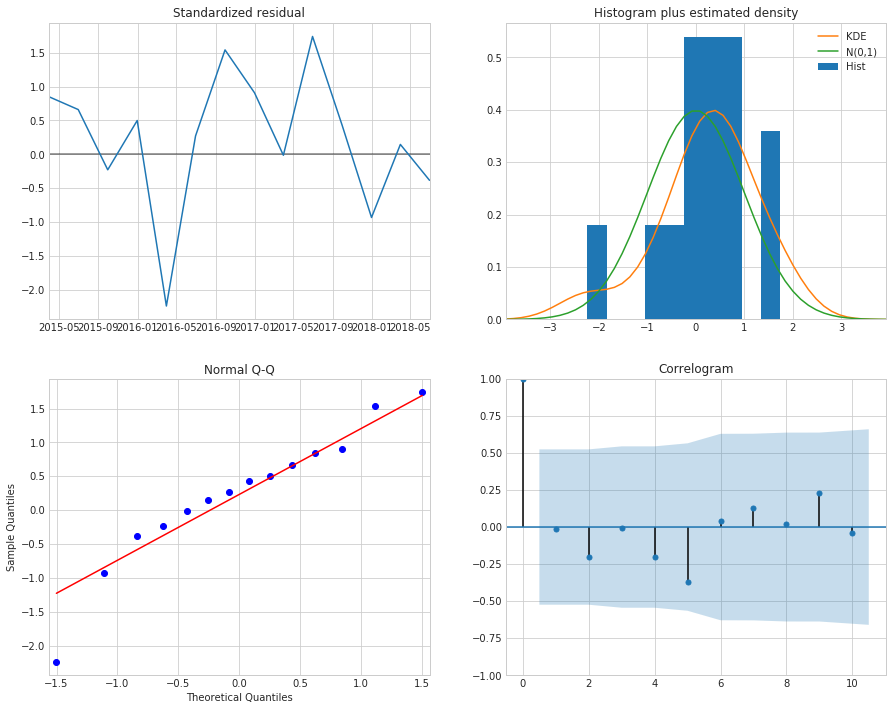

In [69]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Остатки стационарные, если судить по диагностической модели. Есть незначительные выбросы в распределении остатков.

Выведем результат моделирования. 

In [70]:
results.fittedvalues

Xm
2015-03-31       0.000000
2015-06-30    4268.691543
2015-09-30    4476.361287
2015-12-31    4404.057502
2016-03-31    4476.743491
2016-06-30    3928.170836
2016-09-30    3837.397938
2016-12-31    4329.858637
2017-03-31    3749.498271
2017-06-30    4092.081331
2017-09-30    4825.683664
2017-12-31    5046.604861
2018-03-31    4467.264184
2018-06-30    5142.670293
Freq: Q-DEC, dtype: float64

Так как моедль использует скользящую среднюю, нет прогноза для первого квартала. Оценим точность модели на тренировочных данных.

In [71]:
predict=results.get_prediction(start=pd.to_datetime('2015-06-30'))
metrics(train['2015-06-30':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -2.447
	P-значение = 0.129
Критические значения :
	1%: -4.6651863281249994 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.3671868750000002 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.802960625 - Данные не стационарны с вероятностью 90% процентов
MAD: 291.5517
MSE: 152989.5186
MAPE: 0.0686
MPE: 0.0081
Стандартная ошибка: 391.1387


Как мы видим, остатки не стационарны. Мы не можем использовать эту модель для прогнозирования. Но ради любопытства попробуем сравнить ее результаты с тестовыми данными. 

In [76]:
metrics_short(test, results.forecast(len(test)))

MAD: 477.4713
MSE: 232551.6318
MAPE: 0.0975
MPE: 0.0117
Стандартная ошибка: 482.2361


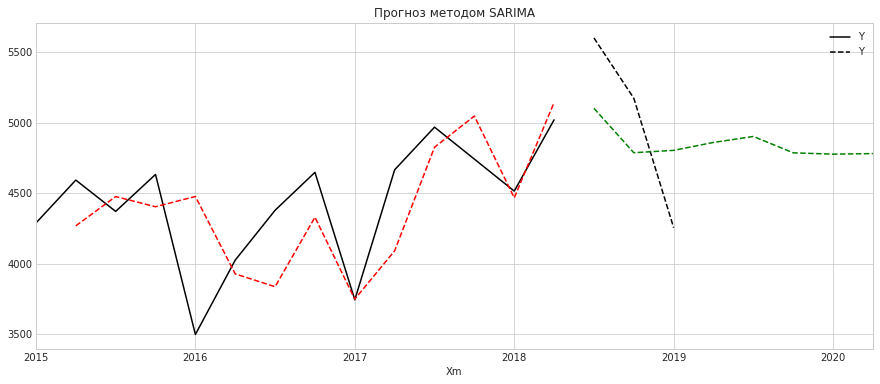

In [77]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
test.plot(ax=ax, style='--', color='black')
predict.predicted_mean.plot(ax=ax, style='--', color='red')
results.forecast(8).plot(ax=ax, style='--', color='green')
plt.show()

Как мы видим, действительно модель не адекватна. Ее движение расходится с фактическими значениями и модель выраждается в прямую. 

Прежде чем делать выводы. попробуем объяснить колебания ряда через другие переменные.

# Множественная линейная регрессия

**Методические указания**: *не обязательно для выполнения в рамках межмодульной работы*

Прочитаем с листа RG данные для регрессии. 

In [112]:
dfR=pd.read_excel("sample_dataset.xlsx",  sheet_name='RG')
dfR.head()

,Xm,N,Y,Сортировка контейнеров,Ср.сут. кол-во вагонов,Цена,Расходы на рекламу
0,2015-01-01,1,1388,117,25,50,125
1,2015-02-01,2,1088,119,25,50,125
2,2015-03-01,3,1813,124,27,50,200
3,2015-04-01,4,1523,126,29,50,200
4,2015-05-01,5,1595,127,30,50,250


N - номер квартала по порядку, будет задавать тренд. Также Количество отсортированных контейнеров, среднесуточное количество вагонов, стоимость и расходы на рекламу. 

In [113]:
dfR.describe()

,N,Y,Сортировка контейнеров,Ср.сут. кол-во вагонов,Цена,Расходы на рекламу
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000
mean,24.50,1558.187500,131.979167,31.145833,65.000000,191.666667
std,14.00,321.445979,11.170801,5.418603,11.298654,51.913731
min,1.00,997.000000,117.000000,18.000000,50.000000,125.000000
25%,12.75,1333.500000,125.750000,27.750000,57.500000,125.000000
50%,24.50,1533.500000,130.000000,32.000000,65.000000,200.000000
75%,36.25,1738.750000,137.250000,35.000000,72.500000,250.000000
max,48.00,2268.000000,162.000000,42.000000,80.000000,250.000000


Мы видим, что в данных нет пропусков. Посомтрим на нормальность распределдения количество обработанных контейнеров (Y).

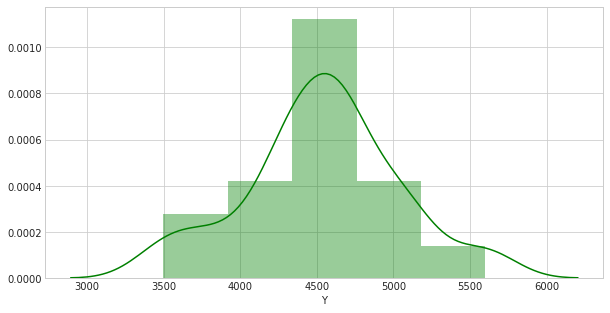

In [114]:
plt.figure(figsize=(10,5))
sns.distplot(df['Y'], color='g', hist_kws={'alpha':0.4}, bins=5)

Мы видим, что количество обработанных контейнеров имеют нормальное распределение. 

Посомтрим на парные распределения и завсимости.

In [115]:
dfR.columns

Index(['Xm', 'N', 'Y', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45498a4438>,
      dtype=object)

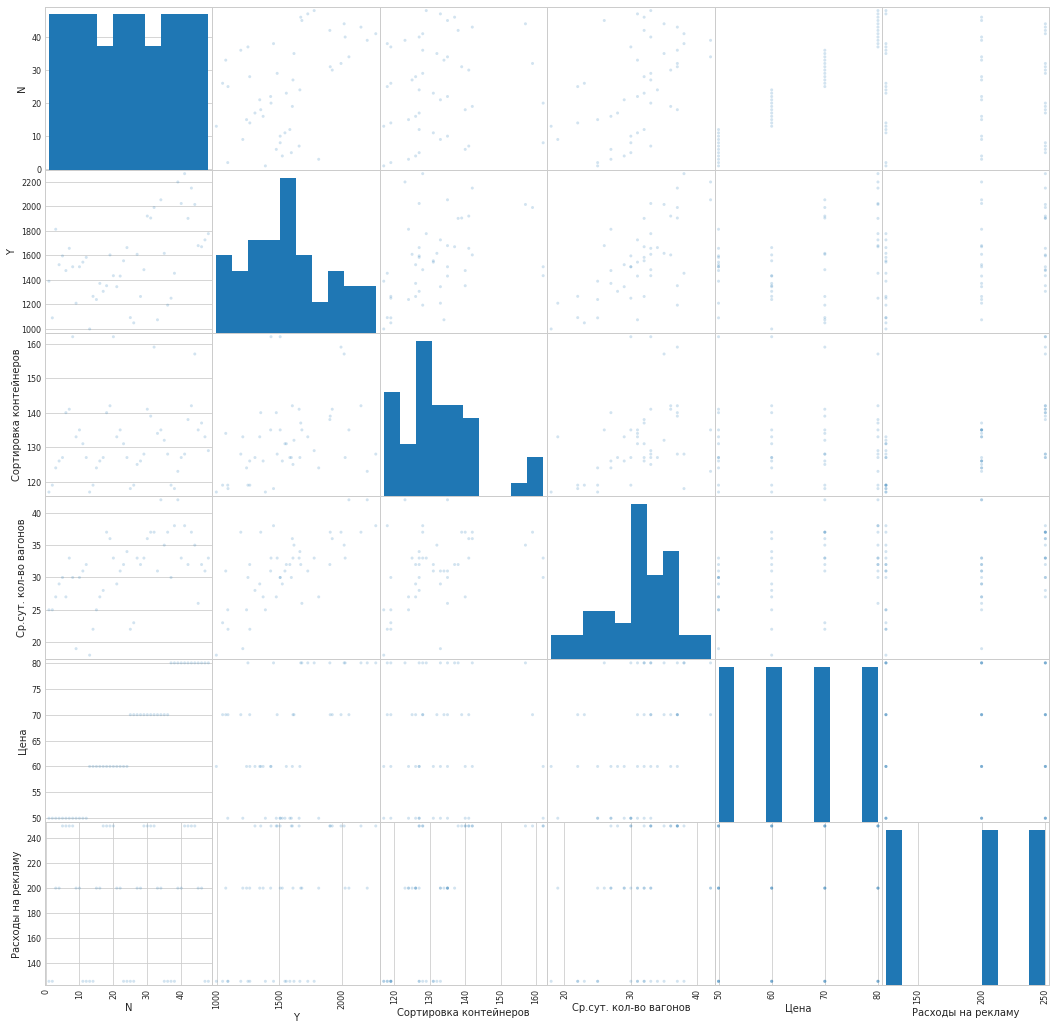

In [116]:
scatter_matrix(dfR[['N', 'Y', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу']], figsize=(18,18), alpha=0.2)

Судя по распределению, "Сортировка контейнеров" может быть причиной аномалий.

Посмотрим на парные корреляции. 

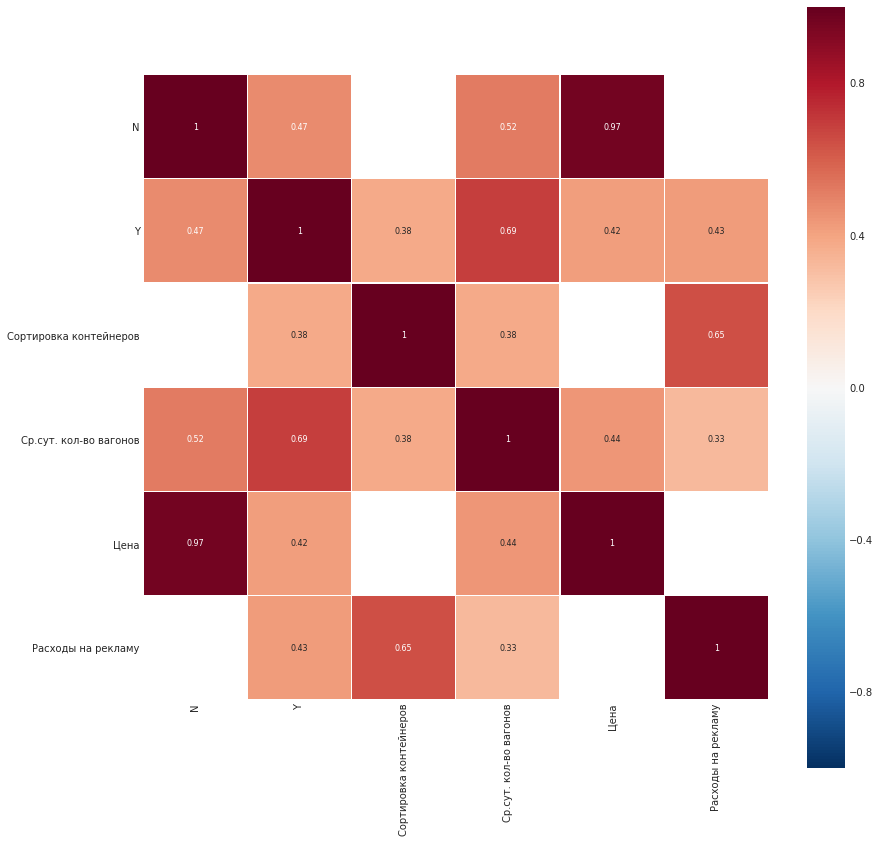

In [117]:
h_map(dfR, 0.3)

<Figure size 1008x1008 with 0 Axes>

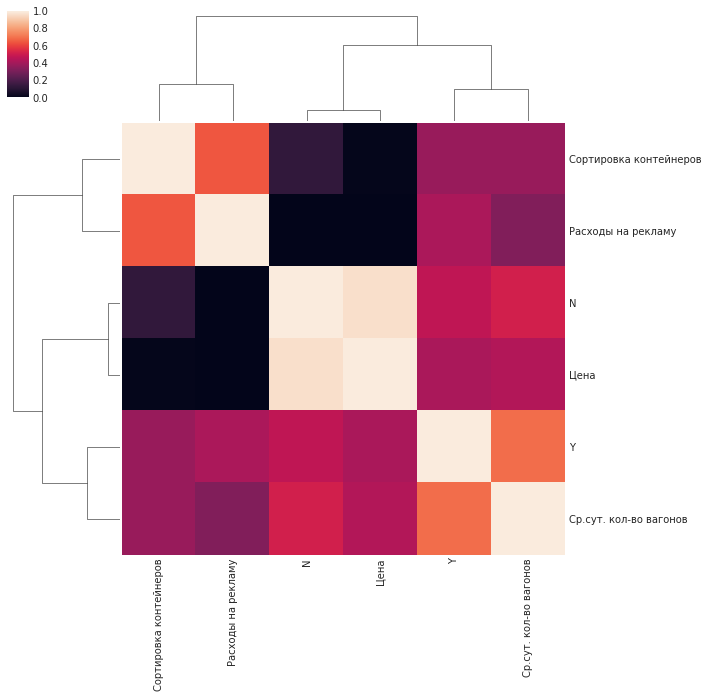

In [118]:
plt.figure(figsize=(14,14))
sns.clustermap(dfR.corr())

Скорее всего, мы столкнемся с эффектом мультиколлинеарности. В частности, цена и порядковый номер имеют высокую взаимозависимость.

In [119]:
dfR.columns

Index(['Xm', 'N', 'Y', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу'],
      dtype='object')

In [120]:
col=['N', 'Сортировка контейнеров', 'Ср.сут. кол-во вагонов',
       'Цена', 'Расходы на рекламу']
#Разделим на влияющие и целевую переменную
X=dfR[col]
Y=dfR['Y']

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     10.59
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           1.26e-06
Time:                        17:21:00   Log-Likelihood:                -325.12
No. Observations:                  48   AIC:                             662.2
Df Residuals:                      42   BIC:                             673.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    539

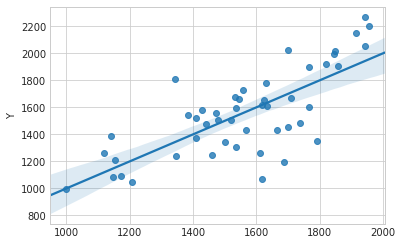

In [121]:
X=sm.add_constant(X)

reg = sm.OLS(Y, X)
res=reg.fit()
print(res.summary())
r=res.predict(X)
r=np.array(res)
sns.regplot(res.fittedvalues.copy(), Y)
plt.show()

Как и ожидали, мы не можем использовать модель со всем набором данных. Выполним перебор параметров и найдем оптимальную модель.

In [122]:
res=get_factors(dfR[col], dfR['Y'], col)

Количество комбинаций  32
Результаты перебора в порядке возрастания MSE:
          MSE        r2                      Переменные
0  60462.1998  0.402399  [N, Расходы на рекламу, const]
1  78796.4952  0.221185                      [N, const]
2  82840.5653  0.181214     [Расходы на рекламу, const]
3  83242.2974  0.177243                   [Цена, const]


In [107]:
res.loc[0]

MSE                                  60462.2
r2                                  0.402399
Переменные    [N, Расходы на рекламу, const]
Name: 0, dtype: object

Вверху параметры лучшей модели. Невысокий показатель R2. Попробуем построить модель.

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     15.15
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           9.32e-06
Time:                        17:21:12   Log-Likelihood:                -332.34
No. Observations:                  48   AIC:                             670.7
Df Residuals:                      45   BIC:                             676.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
N                     10.7984      2

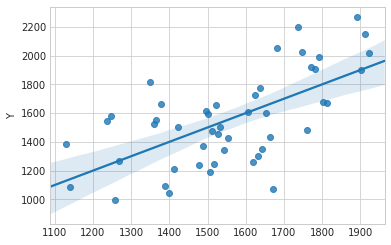

In [123]:
Y=dfR['Y']
dfR=sm.add_constant(dfR)
#укажем пермеенные, которые будем использовать в качестве регрессоров
X=dfR[['N', 'Расходы на рекламу', 'const']]
reg = sm.OLS(Y, X)
res=reg.fit()
print(res.summary())
sns.regplot(res.fittedvalues.copy(), Y)
plt.show()

In [134]:
metrics(dfR.Y, res.fittedvalues)

Тест на стационарность:
	T-статистика = -5.725
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные  стационарны с вероятностью 90% процентов
MAD: 207.1159
MSE: 60462.1998
MAPE: 0.1413
MPE: -0.0264
Стандартная ошибка: 245.8906


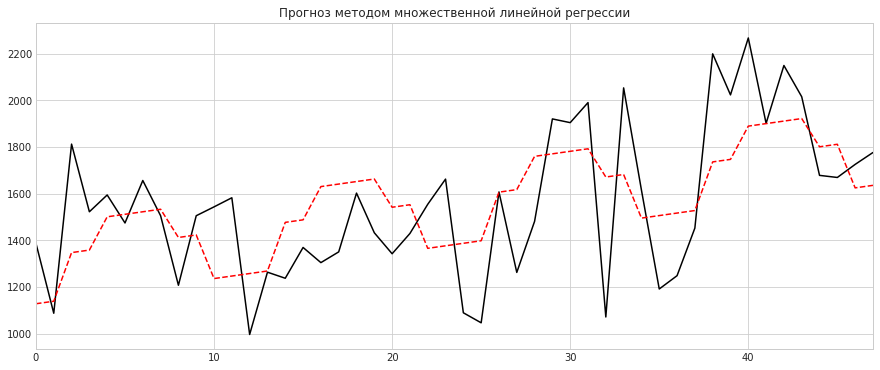

In [161]:
ax = dfR.Y.plot(figsize=(15,6), color='black', title="Прогноз методом множественной линейной регрессии" )
res.fittedvalues.plot(ax=ax, style='--', color='red')
plt.show()

Модель множественной линейной регрессии лучшая в настоящее время по точности прогноза. Есть потенциал для ее улучшения. Но использовать мы ее не множем, так как у нас отсутствует план инвестиций в рекламу. 

# Общие выводы и корректировка

Лучше всего себя показала модель Хольта-Винтерса (адитивный тренд и мультипликативная сезонность) где использовались данные по кварталам.

Натренируем модель на полном масштабе данных и сделаем прогноз на четыре квартала вперед.

На всякий случай, прочитаем оригинальные данные и выполним корректировки.

In [174]:
df=pd.read_excel("sample_dataset.xlsx", index_col='Xm', sheet_name='Data')
df.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [175]:
df.loc['2018-03-01'].Y=df.loc['2015-03-01'].Y
df.loc['2018-04-01'].Y=df.loc['2015-04-01'].Y
df.loc['2018-05-01'].Y=df.loc['2015-05-01'].Y
df.loc['2018-07-01'].Y=df.loc['2017-07-01'].Y

In [176]:
df=df[:"2019-03-01"].resample('Q').sum()

In [177]:
df.loc['2017-12-31']=(df.loc['2017-09-30']+df.loc['2018-03-31'])/2

In [178]:
fit1 = ExponentialSmoothing(df, seasonal_periods=4, trend='add', seasonal='mul').fit()
metrics(df, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -3.469
	P-значение = 0.009
Критические значения :
	1%: -3.9240193847656246 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.0684982031250003 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.67389265625 - Данные  стационарны с вероятностью 90% процентов
MAD: 266.3314
MSE: 98635.7792
MAPE: 0.0594
MPE: 0.0004
Стандартная ошибка: 314.0633


In [179]:
forecast=fit1.forecast(4)
forecast

2019-06-30    4974.456921
2019-09-30    5343.802928
2019-12-31    5007.343578
2020-03-31    4536.112495
Freq: Q-DEC, dtype: float64

Считаю, что осуществление реконструкции терминала и повышение расходов в рекламу позволит достичь результата на 10% больше материматической.

In [180]:
forecast.loc['2019-12-31']=5007*1.1
forecast.loc['2020-03-31']=4536*1.1

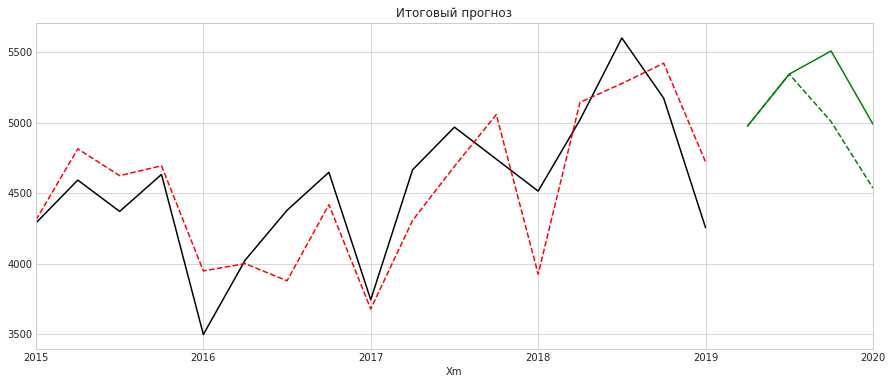

In [183]:
ax = df.Y.plot(figsize=(15,6), color='black', title="Итоговый прогноз" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(4).plot(ax=ax, style='--', color='green')
forecast.plot(ax=ax, color='green')
plt.show()

Сплошная зеленая линия - экспертная корректировка математического прогноза. Прерывистая зеленая линия - математический прогноз.

# Выводы по итогам материматического прогнозирования

Все модели за исключениям модели SARIMA по кварталам оказались адекватными и пригодными для прогнозирования. Самый точный прогноз тестовых данных удалось сделать поквартально методом Хольта-Винтерса с адитивным трендом и мультипликативной сезонностью. 

большие перспективы для помесечного прогнозирования при дальнейшей проработке может показать модель множественной регрессии по месяцам. 

**Методические указания**: *итоговый прогноз (корректировка экспертом математической модели) можно представить в Excel.*

# Модель Монте-Карло

**Описание модели:**

Надо сбалансировать фронт подачи вагонов и количество грузоподъемных механизмов, для того, чтобы в 90% случаев обрабатывать прибывшие контейнера в одну подачу.

Существующий фронт подачи вагонов на условном контейнерном терминале – 30 усл.ваг. Для моделирования использовались данные тактического прогноза переработки контейнеров. При данном фронте в среднем вагоны обрабатываются, в 27% случаев в одну подачу, в 60% случаев в 2 подачи, и в 13% случаев в 3 подачи. Необходимость производить маневровую работу существенно увеличивает время обработки контейнеров, тем самым увеличивая срок доставки груза.

Моделирование будем производить исходя из самого загруженного месяца мая 2018 года.

**Данные**

Из файла Excel загрузим статистику по поступлению контейнеров. Также мы знаем, что один грузоподъемный механизм обрабатывает 30 условных вагонов (60 контейнеров):
- 5 часов - 10 раз
- 6 часов - 15 раз
- 7 часов - 5 раз.

Норматив обработки 11 часов на один грузоподъемный механизм. Из-за отсутсвия точных замеров времени на обработку одной подачи, предположим, что это треугольное распределение с наиболее ожидаемым значение 5.7 часа.

Количество иттераций для экспериментов 1000, зададим в переменной size.

(array([ 39.,  91., 138., 190., 150., 150., 100.,  67.,  56.,  19.]),
 array([5.02396028, 5.2187109 , 5.41346152, 5.60821214, 5.80296276,
        5.99771338, 6.19246401, 6.38721463, 6.58196525, 6.77671587,
        6.97146649]),
 <a list of 10 Patch objects>)

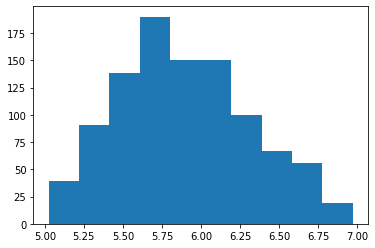

In [8]:
size = 1000

tpod = np.random.triangular(left = 5, mode = 5.7, right = 7, size = size)
plt.hist(tpod)

Загрузим статистику поступления вагонов за месяц с листа "МК" и изучим параметры распределения.

In [29]:
df=pd.read_excel("sample_dataset.xlsx", sheet_name='MK')
df.head()

,май 2018,Контейнера,Вагоны
0,1,55,28
1,2,64,32
2,3,82,42
3,4,93,47
4,5,48,24


In [30]:
df.describe()

,май 2018,Контейнера,Вагоны
count,30.000000,30.000000,30.000000
mean,15.500000,75.600000,37.966667
std,8.803408,28.673669,14.530547
min,1.000000,35.000000,18.000000
25%,8.250000,50.500000,25.750000
50%,15.500000,78.500000,39.000000
75%,22.750000,93.000000,47.000000
max,30.000000,125.000000,63.000000


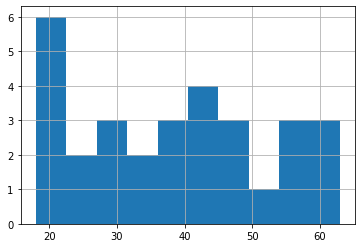

In [31]:
df['Вагоны'].hist()

Поступление вагонов похоже на равномерное распределение. Его и будем использовать для моделирования с границами минимум 18, максимум 63 вагона.

(array([ 96.,  92., 109.,  87.,  93., 120.,  96.,  97.,  85., 125.]),
 array([18. , 22.4, 26.8, 31.2, 35.6, 40. , 44.4, 48.8, 53.2, 57.6, 62. ]),
 <a list of 10 Patch objects>)

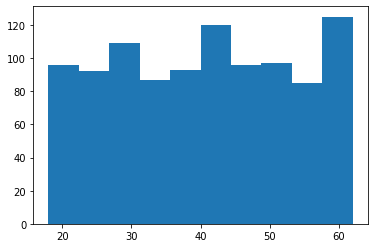

In [7]:
vagon = np.random.uniform(low = 18, high = 63, size = size).astype(int)
plt.hist(vagon)

Построим модель для одного механизма. Из бюджета времени одного грузоподъемного механизма будем вычитать количество подач. Которое рассчитаем как бюджет времени одного механизма минус количество подач умножить на смоделированное время по их переработке. Если время превышает бюджет, отрицательное значение, значит мы не смогли в течении дня переработать все поступления. 

**Методические указания**: для массивов numpy командой *.astype(int)* мы приводим значения к целым числам. Вернее, данная команда отбрасывает дроную часть. И если у нас получилось значение 0.89, то результат преобразования будет 0. По этой причине добавляем 1.

Если возникнут затруднения с моделированием, обращайтесь к преподавателю курса.

Случаи превышения времени: 622


(array([ 13.,  38.,  25.,   3.,  96., 385., 195.,   0.,  11., 234.]),
 array([-9.44069736, -7.90850981, -6.37632226, -4.84413471, -3.31194716,
        -1.77975961, -0.24757206,  1.28461549,  2.81680304,  4.34899059,
         5.88117814]),
 <a list of 10 Patch objects>)

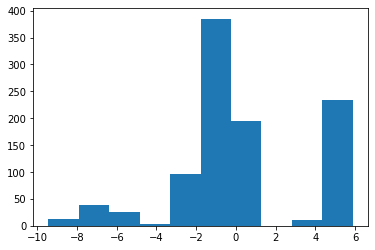

In [9]:
budget_one=11
front=30
time_for_work=budget_one-((vagon/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Более чем в 662 случаев из 1000, один грузоподъемный механизм не укладывается в бюджет времени при работе в самый напряженный месяц.  Причем, значительное количество отклонений не значительное, не более двух часов. Стоит поискать возмоности для оптимизации работы, чтобы справляться одним механизмом. 

Изучим результаты моделирования для двух механизмов.

Случаи превышения времени: 0


(array([ 13.,  38.,  25.,   3.,  96., 385., 195.,   0.,  11., 234.]),
 array([ 1.55930264,  3.09149019,  4.62367774,  6.15586529,  7.68805284,
         9.22024039, 10.75242794, 12.28461549, 13.81680304, 15.34899059,
        16.88117814]),
 <a list of 10 Patch objects>)

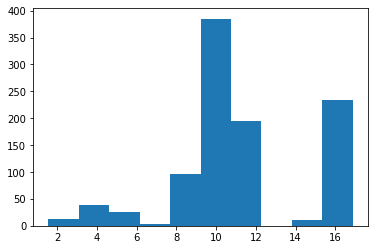

In [32]:
budget_one=11*2
front=30
time_for_work=budget_one-((vagon/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Два грузоподъемных механизма с большим запасом справляются с работой и значительную часть времени простаивают.

Попробуем подобрать значение потока вагонов, которое могут обсужить два механизма при том же распределении времени обслуживания одной подачи. Будем генерировать равномерную подачу вагонов.

Моделирование производилось в диапазоне от 50 до 100 вагонов в сутки.

Случаи превышения времени: 0


(array([ 19.,  56.,  67., 100., 150., 150., 190., 138.,  91.,  39.]),
 array([1.08560053, 1.66985239, 2.25410426, 2.83835612, 3.42260798,
        4.00685985, 4.59111171, 5.17536357, 5.75961544, 6.3438673 ,
        6.92811917]),
 <a list of 10 Patch objects>)

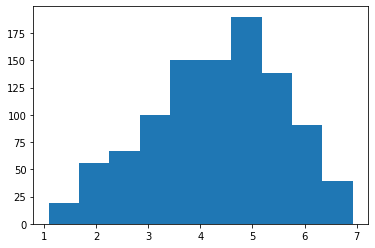

In [27]:
budget_one=11*2
front=30
vagon2=np.array([89 for x in range(0,1000)])
time_for_work=budget_one-((vagon2/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Случаи превышения времени: 808


(array([ 19.,  56.,  67., 100., 150., 150., 190., 138.,  91.,  39.]),
 array([-5.88586596, -5.10686348, -4.32786099, -3.54885851, -2.76985602,
        -1.99085354, -1.21185105, -0.43284857,  0.34615392,  1.1251564 ,
         1.90415889]),
 <a list of 10 Patch objects>)

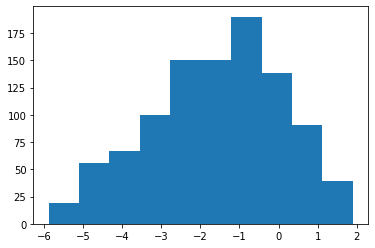

In [28]:
budget_one=11*2
front=30
vagon2=np.array([90 for x in range(0,1000)])
time_for_work=budget_one-((vagon2/front).astype(int)+1)*tpod
print('Случаи превышения времени:', (time_for_work<0).sum())
plt.hist(time_for_work)

Мы видим, что два грузоподъмных механизма могут гарантированно и с запасом обслуживать до 90 вагонов, что соотвествует трем подачам в сутки. Но в данном случае, имеет смысл увеличить фронт подачи вагонов до полезной длины в 45 усл. вагонов.